# Do you need psuedo labels?

# You might need a token for space itself? start and stop tokens?

1. https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention
2. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention

# Sentiment Classification model with test as well in train? Will increase the vocab size as well?

# * https://www.tensorflow.org/tutorials/text/transformer
# * https://pytorch.org/tutorials/beginner/transformer_tutorial.html

## Settings

In [140]:
# CONTROLS
MODEL_PREFIX = "V14"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.3
MIN_LR = 1e-6
MAX_LR = 1e-3
BATCH_SIZE = 1024
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 10
CLR_METHOD = "triangular" # exp_range, triangular, triangular2
NUM_EPOCHS = 100

## Libraries

In [141]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import pickle, os, sys, re

import spacy
from spacy.lang.en import English

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, MaxPooling1D, Layer
from tensorflow.keras.activations import softmax
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

%matplotlib inline

In [142]:
#https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(Attention,self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [143]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [144]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(54321)

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Import Data

In [145]:
df = pd.read_csv("../data/train.csv",
                 encoding="utf8")

print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(2)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID  \
count   27481        
unique  27481        
top     a51c8a2f9c   
freq    1            

                                                              text  \
count   27480                                                        
unique  27480                                                        
top     going to look in the refrigerator for a taste snack to eat   
freq    1                                                            

       selected_text sentiment  
count   27480         27481     
unique  22463         3         
top     good          neutral   
freq    199           11118     


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [146]:
test_df = pd.read_csv("../data/test.csv")
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(2)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID  \
count   3534         
unique  3534         
top     bacb2d1061   
freq    1            

                                                                                     text  \
count   3534                                                                                
unique  3534                                                                                
top     _twitz lol...hiiii yourself. Maybe lay off the patron and down a bottle of water!   
freq    1                                                                                   

       sentiment  
count   3534      
unique  3         
top     neutral   
freq    1430      


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive


In [147]:
df.loc[df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,selected_text,sentiment
44,c77717b103,I love to! But I`m only available from 5pm. and where dear? Would love to help convert her vids.ï¿½,I love to!,positive
192,28dbada620,*phew* Will make a note in case anyone else runs into the same issueï¿½,*phew* Will make a note in case anyone else runs into the same issueï¿½,neutral


In [148]:
test_df.loc[test_df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,sentiment
145,7223fdccc2,tikcets are only ï¿½91...each...BUT I SO WANT TO GO,positive
618,43ad351369,"AHHH - Whatchu talkinï¿½ baby? HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s",positive


## Exploration

#### Sentiment count in training

In [149]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


## Preprocessing

#### Cleaning

In [150]:
# For traceability
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [151]:
print(df.shape)
df = df[(~df.text.isna())]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27481, 5)
(27480, 5)


In [152]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

In [153]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

#### Tagging

In [154]:
def preprocess_text(x, extra_string=None):
    x = x.lower()
    #x = re.sub('([!"#$%&()*+,-./:;\'<=>?@[\\]^_{|}~\t\n])', ' \\1 ', x) # Not including ` here since used in couldn`t, isn`t
    x = x.strip()
    x = re.sub(' +', ' ', x)
    x = x.split(" ")
    if extra_string is not None:
        x = ["xxxSTART"] + x + ["xxxSENTIMENT"] + [extra_string] + ["xxxEND"]
    return x

In [155]:
def get_extremities(l_string, s_string, extra_string, print_it=False):
    l_string = preprocess_text(l_string, extra_string)
    s_string = preprocess_text(s_string, extra_string=None)
    
    len_l = len(l_string)
    len_s = len(s_string)
    
    for i in range(len_l - len_s + 1):
        if (i + len_s) <= len_l:
            substring = l_string[i:i+len_s]
            if substring == s_string:
                if print_it:
                    print(l_string)
                    print(substring)
                    print(i, i+len_s, substring)
                
                start_vector, end_vector = np.zeros(len_l, dtype=np.int16), np.zeros(len_l, dtype=np.int16)
                att_vector = np.ones(len_l, dtype=np.int16)
                start_vector[i], end_vector[i+len_s-1] = 1, 1
                
                return (l_string, s_string, start_vector, end_vector, att_vector)

In [156]:
idx = 100
get_extremities(df.text[idx], df.selected_text[idx], df.sentiment[idx], print_it=False)

(['xxxSTART',
  '4am.',
  'and',
  'im',
  'on',
  'the',
  'beach.',
  'pretty',
  'xxxSENTIMENT',
  'positive',
  'xxxEND'],
 ['pretty'],
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int16))

In [157]:
df[["text_mod", "selected_text_mod", "target_start", "target_stop", "target_atten"]] = df.apply(lambda x: get_extremities(x.text, x.selected_text, x.sentiment), axis=1).apply(pd.Series)
test_df[["text_mod"]] = test_df.apply(lambda x: [preprocess_text(x.text, extra_string = x.sentiment)], axis=1).apply(pd.Series)

In [158]:
df.isna().sum()

textID               0   
text                 0   
selected_text        0   
sentiment            0   
original_index       0   
sentiment_code       0   
text_mod             2930
selected_text_mod    2930
target_start         2930
target_stop          2930
target_atten         2930
dtype: int64

In [159]:
test_df.isna().sum()

textID            0
text              0
sentiment         0
original_index    0
sentiment_code    0
text_mod          0
dtype: int64

In [160]:
df.head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0,neutral,"[xxxSTART, i`d, have, responded,, if, i, were, going, xxxSENTIMENT, neutral, xxxEND]","[i`d, have, responded,, if, i, were, going]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1,negative,"[xxxSTART, sooo, sad, i, will, miss, you, here, in, san, diego!!!, xxxSENTIMENT, negative, xxxEND]","[sooo, sad]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [161]:
df.iloc[df.loc[df['target_start'].isna()].index].head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
2,088c60f138,my boss is bullying me...,bullying me,negative,2,negative,NaN,NaN,NaN,NaN,NaN
18,af3fed7fc3,is back home now gonna miss every one,onna,negative,18,negative,NaN,NaN,NaN,NaN,NaN


In [162]:
test_df.head(2)

,textID,text,sentiment,original_index,sentiment_code,text_mod
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,0,neutral,"[xxxSTART, last, session, of, the, day, http://twitpic.com/67ezh, xxxSENTIMENT, neutral, xxxEND]"
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive,1,positive,"[xxxSTART, shanghai, is, also, really, exciting, (precisely, --, skyscrapers, galore)., good, tweeps, in, china:, (sh), (bj)., xxxSENTIMENT, positive, xxxEND]"


In [163]:
anomalous_idxs = df.loc[df['target_start'].isna()].index.tolist()

In [164]:
print(df.shape)
df = df[~df.index.isin(anomalous_idxs)]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27480, 11)
(24550, 11)


#### Random Shuffle and Train Val Indices

In [165]:
idx = [i for i in np.arange(df.shape[0])]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO*len(Y))], idx[round(TRAIN_SPLIT_RATIO * len(Y)):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

24550 19640 4910 24550


#### Tokenization

In [166]:
X_words = df['text_mod'].apply(lambda x:list(x)).tolist()
X_att = df['target_atten'].apply(lambda x:list(x)).tolist()

X_words_train = [X_words[i] for i in train_idx]
X_words_val = [X_words[i] for i in val_idx]

X_words_test = test_df['text_mod'].apply(lambda x:list(x)).tolist()
X_att_test = [[1 for j in i] for i in X_words_test]

Y_words = df['selected_text_mod'].apply(lambda x:list(x)).tolist()
Y_starts = df['target_start'].apply(lambda x:list(x)).tolist()
Y_stops = df['target_stop'].apply(lambda x:list(x)).tolist()

print("\n",
    "X_words:","\t", len(X_words),"\n",
    "X_att:","\t", len(X_att),"\n",
    "Y_words:","\t", len(Y_words),"\n",
    "Y_starts:","\t", len(Y_starts),"\n",
    "Y_stops:","\t", len(Y_stops),"\n",
    "X_words_test:","\t", len(X_words_test),"\n",
    "X_att_test:","\t", len(X_att_test),"\n"
)


 X_words: 	 24550 
 X_att: 	 24550 
 Y_words: 	 24550 
 Y_starts: 	 24550 
 Y_stops: 	 24550 
 X_words_test: 	 3534 
 X_att_test: 	 3534 



In [167]:
print(sum([len(i)==len(j) for i,j in zip(X_att_test, X_words_test)]))
print(sum([len(i)==len(j) for i,j in zip(X_att, X_words)]))

3534
24550


In [168]:
from collections import Counter
word_counts = Counter([j for i in X_words_train for j in i])

X_unique_tokens = len(word_counts)
word_counts.most_common(10)

[('xxxSTART', 19640),
 ('xxxSENTIMENT', 19640),
 ('xxxEND', 19640),
 ('i', 9132),
 ('neutral', 8599),
 ('to', 7173),
 ('the', 6335),
 ('positive', 5775),
 ('negative', 5277),
 ('a', 4824)]

In [169]:
MIN_WORD_FREQ = 2

In [170]:
word_subset = [i for i,j in word_counts.items() if j >= MIN_WORD_FREQ]
print("VOCAB reduced from", len(word_counts), "to", len(word_subset))

VOCAB reduced from 34879 to 10341


In [171]:
vocab_itos = {i+2:j for i,j in enumerate(word_subset)}
vocab_stoi = {j:i+2 for i,j in enumerate(word_subset)}

vocab_stoi["xxxUNK"] = 1
vocab_itos[1] = "xxxUNK"

vocab_stoi["xxxNone"] = 0
vocab_itos[0] = "xxxNone"

In [172]:
def get_from_vocab(vocab, word):
    try:
        value = vocab[word]
    except KeyError as k:
        value = vocab_stoi["xxxUNK"]
    return value

In [173]:
X = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words]
Y = [[get_from_vocab(vocab_stoi,j) for j in i] for i in Y_words]
X_test = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words_test]

In [174]:
max_len = max([len(i) for i in X])
VOCAB_SIZE = len(vocab_stoi)
print(VOCAB_SIZE, max_len)

10343 37


#### Train Validation  split

In [175]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_att_train, X_att_val = [X_att[i] for i in train_idx], [X_att[i] for i in val_idx]

Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y_starts_train, Y_starts_val = [Y_starts[i] for i in train_idx], [Y_starts[i] for i in val_idx]
Y_stops_train, Y_stops_val = [Y_stops[i] for i in train_idx], [Y_stops[i] for i in val_idx]

print("\n",
    len(X_train),"\t",": X_train","\n",
    len(X_att_train),"\t",": X_att_train","\n",
    len(Y_train),"\t",": Y_train","\n",
    len(Y_starts_train),"\t",": Y_starts_train","\n",
    len(Y_stops_train),"\t",": Y_stops_train","\n",
    len(X_val),"\t",": X_val","\n",
    len(X_att_val),"\t",": X_att_val","\n",
    len(Y_val),"\t",": Y_val","\n",
    len(Y_starts_val),"\t",": Y_starts_val","\n",
    len(Y_stops_val),"\t",": Y_stops_val","\n"
)


 19640 	 : X_train 
 19640 	 : X_att_train 
 19640 	 : Y_train 
 19640 	 : Y_starts_train 
 19640 	 : Y_stops_train 
 4910 	 : X_val 
 4910 	 : X_att_val 
 4910 	 : Y_val 
 4910 	 : Y_starts_val 
 4910 	 : Y_stops_val 



#### Padding

In [176]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [177]:
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
X_att_train = pad_sequences(X_att_train, maxlen=max_len, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post")
Y_starts_train = pad_sequences(Y_starts_train, maxlen=max_len, padding="post")
Y_stops_train = pad_sequences(Y_stops_train, maxlen=max_len, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
X_att_val = pad_sequences(X_att_val, maxlen=max_len, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post")
Y_starts_val = pad_sequences(Y_starts_val, maxlen=max_len, padding="post")
Y_stops_val = pad_sequences(Y_stops_val, maxlen=max_len, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len, padding="post")
X_att_test = pad_sequences(X_att_test, maxlen=max_len, padding="post")

In [178]:
print("\n",
     X_train.shape, "\t: X_train ", "\n",
     X_att_train.shape, "\t: X_att_train ", "\n",
     Y_train.shape, "\t: Y_train ", "\n",
     Y_starts_train.shape, "\t: Y_starts_train ", "\n",
     Y_stops_train.shape, "\t: Y_stops_train ", "\n",

     X_val.shape, "\t: X_val ", "\n",
     X_att_val.shape, "\t: X_att_val ", "\n",
     Y_val.shape, "\t: Y_val ", "\n",
     Y_starts_val.shape, "\t: Y_starts_val ", "\n",
     Y_stops_val.shape, "\t: Y_stops_val ", "\n",

     X_test.shape, "\t: X_test ", "\n",
     X_att_test.shape, "\t: X_att_test ", "\n"
)


 (19640, 37) 	: X_train  
 (19640, 37) 	: X_att_train  
 (19640, 37) 	: Y_train  
 (19640, 37) 	: Y_starts_train  
 (19640, 37) 	: Y_stops_train  
 (4910, 37) 	: X_val  
 (4910, 37) 	: X_att_val  
 (4910, 37) 	: Y_val  
 (4910, 37) 	: Y_starts_val  
 (4910, 37) 	: Y_stops_val  
 (3534, 37) 	: X_test  
 (3534, 37) 	: X_att_test  



#### Checking for zero input vectors

In [179]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 72
0 72


#### Check inputs and outputs

In [180]:
#Train
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_train[num],
                                  X_att_train[num],
                                  Y_train[num],
                                  Y_starts_train[num],
                                  Y_stops_train[num])]

[[2, 1, 25, 0, 0],
 [25, 1, 580, 1, 0],
 [580, 1, 38, 0, 0],
 [38, 1, 581, 0, 0],
 [581, 1, 36, 0, 0],
 [36, 1, 582, 0, 0],
 [582, 1, 25, 0, 0],
 [25, 1, 63, 0, 0],
 [63, 1, 583, 0, 0],
 [583, 1, 20, 0, 0],
 [20, 1, 526, 0, 0],
 [526, 1, 3, 0, 0],
 [3, 1, 508, 0, 0],
 [508, 1, 584, 0, 0],
 [584, 1, 0, 0, 1],
 [585, 1, 0, 0, 0],
 [22, 1, 0, 0, 0],
 [41, 1, 0, 0, 0],
 [24, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]

In [181]:
#Val
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_val[num],
                                  X_att_val[num],
                                  Y_val[num],
                                  Y_starts_val[num],
                                  Y_stops_val[num])]

[[2, 1, 3754, 0, 0],
 [4344, 1, 0, 0, 0],
 [526, 1, 0, 0, 0],
 [628, 1, 0, 0, 0],
 [2877, 1, 0, 0, 0],
 [6599, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [1129, 1, 0, 0, 0],
 [10, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [3754, 1, 0, 1, 1],
 [3754, 1, 0, 0, 0],
 [22, 1, 0, 0, 0],
 [33, 1, 0, 0, 0],
 [24, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]

In [182]:
#Test
num = 100
[[i,j,k] for i,j,k in zip(X_words_test[num],
                          X_test[num],
                          X_att_test[num])]

[['xxxSTART', 2, 1],
 ['oooh,', 1, 1],
 ['sunshine!', 3882, 1],
 ['a', 38, 1],
 ['patch', 6760, 1],
 ['of', 146, 1],
 ['sunshine!', 3882, 1],
 ['and', 13, 1],
 ['it', 20, 1],
 ['will', 436, 1],
 ['be', 311, 1],
 ['gone', 66, 1],
 ['by', 189, 1],
 ['the', 18, 1],
 ['time', 9, 1],
 ['i', 25, 1],
 ['leave', 416, 1],
 ['work', 632, 1],
 ['and', 13, 1],
 ['replaced', 1, 1],
 ['with', 31, 1],
 ['rain.', 860, 1],
 ['/vent', 1, 1],
 ['xxxSENTIMENT', 22, 1],
 ['neutral', 41, 1],
 ['xxxEND', 24, 1]]

## Model

In [183]:
input_att_flags = Input((max_len), name="att_flags")
input_sequences = Input((max_len), name="words")

emb_sequences = Embedding(input_dim=VOCAB_SIZE, input_length=max_len, output_dim=64, mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(32, activation=None, return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(32, activation=None, return_sequences=True))(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(32, activation=None, return_sequences=True))(seq)
seq = Attention(max_len)(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Dense(max_len, activation="relu")(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

att = Dense(max_len, activation="relu")(input_att_flags)
att = BatchNormalization()(att)
att = Dropout(DROPOUT)(att)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(emb_sequences)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Flatten()(convs)
convs = Dense(max_len, activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = Dropout(DROPOUT)(convs)

conv = Multiply()([att, convs])
seq = Multiply()([att, seq])
concat_layer = concatenate([conv, seq])

output_starts = Dense(max_len, activation=None)(concat_layer)
output_starts = BatchNormalization()(output_starts)
output_starts = Activation("relu")(output_starts)
output_starts = Dropout(DROPOUT)(output_starts)

output_starts = Dense(max_len, activation=None)(output_starts)
output_starts = Activation("relu")(output_starts)

output_stops = Dense(max_len, activation=None)(concat_layer)
output_stops = BatchNormalization()(output_stops)
output_stops = Activation("relu")(output_stops)
output_stops = Dropout(DROPOUT)(output_stops)

output_stops = Dense(max_len, activation=None)(output_stops)
output_stops = Activation("relu")(output_stops)

output_starts = Dense(max_len, activation='softmax', name="starts")(output_starts)
output_stops = Dense(max_len, activation='softmax', name="stops")(output_stops)

In [184]:
model = Model([input_att_flags, input_sequences], [output_starts, output_stops])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 37, 64)       661952      words[0][0]                      
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 37, 32)       16416       embedding_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 37, 32)       128         conv1d_3[0][0]                   
____________________________________________________________________________________________

In [185]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam , metrics=['accuracy'])

In [186]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [187]:
history = model.fit(x={"att_flags":X_att_train,
                       "words":X_train},
                    y={"starts":Y_starts_train.argmax(axis=1),
                       "stops":Y_stops_train.argmax(axis=1)},
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=({"att_flags":X_att_val, "words":X_val},
                                     {"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)}),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp,

Train on 19640 samples, validate on 4910 samples
Epoch 1/100
19640/19640 [==============================] - 18s 902us/sample - loss: 7.8349 - starts_loss: 4.1209 - stops_loss: 3.7159 - starts_accuracy: 0.0039 - stops_accuracy: 0.0372 - val_loss: 7.2266 - val_starts_loss: 3.6173 - val_stops_loss: 3.6094 - val_starts_accuracy: 0.0037 - val_stops_accuracy: 0.0644
Epoch 2/100
19640/19640 [==============================] - 6s 310us/sample - loss: 7.7122 - starts_loss: 4.0297 - stops_loss: 3.6816 - starts_accuracy: 0.0047 - stops_accuracy: 0.0438 - val_loss: 7.2128 - val_starts_loss: 3.6094 - val_stops_loss: 3.6035 - val_starts_accuracy: 0.0071 - val_stops_accuracy: 0.0662
Epoch 3/100
19640/19640 [==============================] - 7s 337us/sample - loss: 7.4981 - starts_loss: 3.8754 - stops_loss: 3.6184 - starts_accuracy: 0.0063 - stops_accuracy: 0.0565 - val_loss: 7.1801 - val_starts_loss: 3.5880 - val_stops_loss: 3.5921 - val_starts_accuracy: 0.1153 - val_stops_accuracy: 0.0662
Epoch 4/100

Epoch 27/100
19640/19640 [==============================] - 6s 314us/sample - loss: 3.4482 - starts_loss: 1.4878 - stops_loss: 1.9679 - starts_accuracy: 0.6206 - stops_accuracy: 0.3924 - val_loss: 3.5686 - val_starts_loss: 1.6016 - val_stops_loss: 1.9644 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.4859
Epoch 28/100
19640/19640 [==============================] - 6s 314us/sample - loss: 3.4206 - starts_loss: 1.4722 - stops_loss: 1.9434 - starts_accuracy: 0.6206 - stops_accuracy: 0.4038 - val_loss: 3.4525 - val_starts_loss: 1.5735 - val_stops_loss: 1.8766 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.5073
Epoch 29/100
19640/19640 [==============================] - 6s 314us/sample - loss: 3.3843 - starts_loss: 1.4773 - stops_loss: 1.9032 - starts_accuracy: 0.6206 - stops_accuracy: 0.4145 - val_loss: 3.3291 - val_starts_loss: 1.5318 - val_stops_loss: 1.7946 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.5261
Epoch 30/100
19640/19640 [==============================] 

19640/19640 [==============================] - 6s 299us/sample - loss: 3.0513 - starts_loss: 1.4190 - stops_loss: 1.6392 - starts_accuracy: 0.6206 - stops_accuracy: 0.5186 - val_loss: 2.8835 - val_starts_loss: 1.4369 - val_stops_loss: 1.4456 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.6061
Epoch 54/100
19640/19640 [==============================] - 6s 306us/sample - loss: 3.0536 - starts_loss: 1.4111 - stops_loss: 1.6357 - starts_accuracy: 0.6206 - stops_accuracy: 0.5175 - val_loss: 2.8703 - val_starts_loss: 1.4309 - val_stops_loss: 1.4383 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.6077
Epoch 55/100
19640/19640 [==============================] - 6s 327us/sample - loss: 3.0447 - starts_loss: 1.4209 - stops_loss: 1.6311 - starts_accuracy: 0.6206 - stops_accuracy: 0.5178 - val_loss: 2.8639 - val_starts_loss: 1.4265 - val_stops_loss: 1.4363 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.6069
Epoch 56/100
19640/19640 [==============================] - 6s 306us/sa

19640/19640 [==============================] - 6s 297us/sample - loss: 2.8855 - starts_loss: 1.3732 - stops_loss: 1.5135 - starts_accuracy: 0.6206 - stops_accuracy: 0.5530 - val_loss: 2.7834 - val_starts_loss: 1.3981 - val_stops_loss: 1.3846 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.6122
Epoch 80/100
19640/19640 [==============================] - 6s 299us/sample - loss: 2.8801 - starts_loss: 1.3686 - stops_loss: 1.5038 - starts_accuracy: 0.6206 - stops_accuracy: 0.5565 - val_loss: 2.7898 - val_starts_loss: 1.3986 - val_stops_loss: 1.3903 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.6092
Epoch 81/100
19640/19640 [==============================] - 6s 312us/sample - loss: 2.8746 - starts_loss: 1.3679 - stops_loss: 1.5025 - starts_accuracy: 0.6206 - stops_accuracy: 0.5605 - val_loss: 2.7936 - val_starts_loss: 1.3917 - val_stops_loss: 1.4010 - val_starts_accuracy: 0.6108 - val_stops_accuracy: 0.5974
Epoch 82/100
19640/19640 [==============================] - 6s 309us/sa

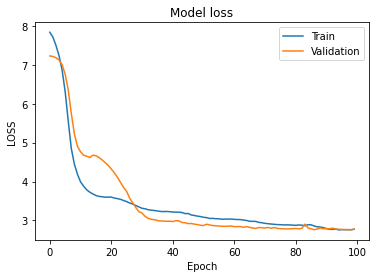

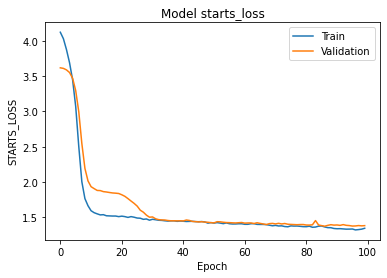

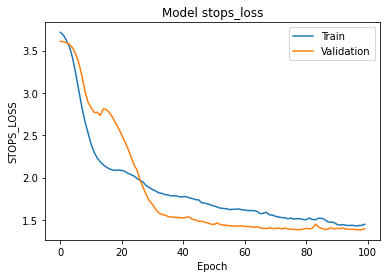

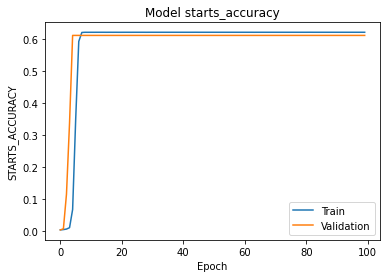

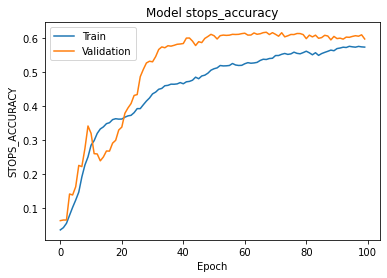

In [188]:
#metric_names = ['loss' ,'accuracy']
metric_names = ["loss", "starts_loss", "stops_loss", "starts_accuracy", "stops_accuracy"]

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Validation

#### Inference

In [189]:
model.save("../results/"+MODEL_PREFIX+"EndCheckpoint.h5")

In [190]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
    custom_objects={'Attention' : Attention},
    compile=True
)

In [191]:
model.evaluate(x = {"att_flags":X_att_val, "words":X_val},
               y={"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)},
               batch_size=PREDICT_BATCH_SIZE)

4910/4910 [==============================] - 1s 287us/sample - loss: 2.7627 - starts_loss: 1.3694 - stops_loss: 1.3892 - starts_accuracy: 0.6108 - stops_accuracy: 0.6071


[2.762722277981201, 1.3694285, 1.3892235, 0.6107943, 0.6071283]

In [192]:
pred_train = model.predict(x = {"att_flags":X_att_train, "words":X_train},
                           batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = {"att_flags":X_att_val, "words":X_val},
                         batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = {"att_flags":X_att_test, "words":X_test},
                          batch_size=PREDICT_BATCH_SIZE)

In [193]:
pred_starts_train, pred_stops_train = pred_train[0], pred_train[1]
pred_starts_val, pred_stops_val = pred_val[0], pred_val[1]
pred_starts_test, pred_stops_test = pred_test[0], pred_test[1]

In [194]:
print(pred_starts_train.shape, pred_stops_train.shape)
print(pred_starts_val.shape, pred_stops_val.shape)
print(pred_starts_test.shape, pred_stops_test.shape)

(19640, 37) (19640, 37)
(4910, 37) (4910, 37)
(3534, 37) (3534, 37)


In [195]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [196]:
preds = {
    "train":{
        "starts":{
            "y_true":Y_starts_train.argmax(axis=1),
            "y_pred":pred_starts_train.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }
    },
    "valid":{
        "starts":{
            "y_true":Y_starts_val.argmax(axis=1),
            "y_pred":pred_starts_val.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }        
    }
}

In [197]:
def print_metrics():
    funcs = [accuracy_score, f1_score, precision_score, recall_score, confusion_matrix]
    for f in funcs:
        for data_set in ["train","valid"]:
            for var in ["starts", "stops"]:
                if f in [accuracy_score]:
                    res = f(**preds[data_set][var])
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
                elif f in [confusion_matrix]:
                    res = f(**preds[data_set][var], labels = np.arange(max_len))
                    np.savetxt(X=res, fmt='%i', delimiter=",",
                               fname="../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                    print("\t||", data_set, "\t||", var, "\t||", f.__name__, "\t||", 
                          "../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                else:
                    res = f(**preds[data_set][var], average="macro")
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
        print("================================================================")

print_metrics()

62.06 	|| train 	|| starts 	|| accuracy_score
63.67 	|| train 	|| stops 	|| accuracy_score
61.08 	|| valid 	|| starts 	|| accuracy_score
63.67 	|| valid 	|| stops 	|| accuracy_score
2.64 	|| train 	|| starts 	|| f1_score
57.78 	|| train 	|| stops 	|| f1_score
2.62 	|| valid 	|| starts 	|| f1_score
57.78 	|| valid 	|| stops 	|| f1_score
2.14 	|| train 	|| starts 	|| precision_score
56.87 	|| train 	|| stops 	|| precision_score
2.11 	|| valid 	|| starts 	|| precision_score
56.87 	|| valid 	|| stops 	|| precision_score
3.45 	|| train 	|| starts 	|| recall_score
60.04 	|| train 	|| stops 	|| recall_score
3.45 	|| valid 	|| starts 	|| recall_score
60.04 	|| valid 	|| stops 	|| recall_score


c:\users\deepak\miniconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	|| train 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V14_train_starts.csv
	|| train 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V14_train_stops.csv
	|| valid 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V14_valid_starts.csv
	|| valid 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V14_valid_stops.csv


#### Postprocessing

In [198]:
Y_words_train = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_train)]
Y_words_val = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_val)]

In [199]:
print(sum([s<e for s,e in zip(pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]))

18948
4736
3417


In [200]:
pred_words_train = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_train], pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]
pred_words_val = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_val], pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]
pred_words_test = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_test], pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]

In [201]:
def jaccard(str1, str2):
    a = set(str1)
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [202]:
print("Training Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_train, pred_words_train)]))
print("Validation Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_val, pred_words_val)]))

Training Jaccard Score 0.6383322141417425
Validation Jaccard Score 0.6272601738910867


In [203]:
sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}

#### Spot Checks

In [204]:
def spot_check(index_to_check, mode):
    print("================== Sample #", index_to_check, "==================")
    if mode == "train":
        print("Selected_text:")
        print('\t', Y_words[train_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_train[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[train_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_train[index_to_check].tolist(),
                                                                                               pred_starts_train[index_to_check].tolist(),
                                                                                               pred_stops_train[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    elif mode == "validation":
        print("Selected_text:")
        print('\t', Y_words[val_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_val[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[val_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_val[index_to_check].tolist(),
                                                                                               pred_starts_val[index_to_check].tolist(),
                                                                                               pred_stops_val[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    else:
        print("Selected_text:")
        print('\t', "Not Available")
        print("Predicted_text:")
        print('\t', pred_words_test[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words_test[index_to_check][num]] for num, (i,j,k) in enumerate(zip(X_test[index_to_check].tolist(),
                                                                                               pred_starts_test[index_to_check].tolist(),
                                                                                               pred_stops_test[index_to_check].tolist())) if i!=0], sep="\n\t")

In [205]:
for i in range(10,20):
    spot_check(i, mode="train")

================== Sample # 10 ==================
Selected_text:
	 ['hanging', 'with', 'the', 'cousin']
Predicted_text:
	 ['hanging', 'with', 'the', 'cousin']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.96', '0.00', 81, 'hanging']
	['0.03', '0.00', 31, 'with']
	['0.01', '0.01', 18, 'the']
	['0.01', '0.98', 82, 'cousin']
	['0.00', '0.00', 22, 'xxxSENTIMENT']
	['0.00', '0.00', 41, 'neutral']
	['0.00', '0.00', 24, 'xxxEND']
================== Sample # 11 ==================
Selected_text:
	 ['listening', 'music', 'with', 'my', 'friend']
Predicted_text:
	 ['listening', 'music', 'with', 'my', 'friend']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.93', '0.00', 83, 'listening']
	['0.04', '0.00', 84, 'music']
	['0.02', '0.00', 31, 'with']
	['0.01', '0.00', 3, 'my']
	['0.00', '0.99', 85, 'friend']
	['0.00', '0.00', 22, 'xxxSENTIMENT']
	['0.00', '0.00', 41, 'neutral']
	['0.00', '0.00', 24, 'xxxEND']
================== Sample # 12 ==================
Selected_text:
	 ['uff', '-', '

In [206]:
for i in range(200,210):
    spot_check(i, mode="validation")

================== Sample # 200 ==================
Selected_text:
	 ['downloadfestival`s', 'lineup', 'isn`t', 'as', 'good', 'as', 'i', 'thought', 'it', 'was.', 'there', 'are', 'some', 'other', 'awesome', 'bands', 'doing', 'the', 'festivals,', 'but', 'missing', 'dl']
Predicted_text:
	 ['xxxUNK', 'xxxUNK', 'isn`t', 'as', 'good', 'as', 'i', 'thought', 'it', 'was.', 'there', 'are', 'some', 'other', 'awesome', 'bands', 'doing', 'the', 'xxxUNK', 'but', 'missing', 'xxxUNK']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.95', '0.00', 1, 'downloadfestival`s']
	['0.01', '0.00', 1, 'lineup']
	['0.00', '0.00', 275, 'isn`t']
	['0.00', '0.00', 214, 'as']
	['0.00', '0.00', 73, 'good']
	['0.00', '0.00', 214, 'as']
	['0.00', '0.00', 25, 'i']
	['0.00', '0.00', 615, 'thought']
	['0.00', '0.00', 20, 'it']
	['0.00', '0.00', 6326, 'was.']
	['0.00', '0.00', 185, 'there']
	['0.00', '0.00', 499, 'are']
	['0.00', '0.00', 642, 'some']
	['0.00', '0.00', 210, 'other']
	['0.00', '0.00', 373, 'awesome']
	['0.0

In [207]:
for i in range(0,20):
    spot_check(i, mode="test")

================== Sample # 0 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['last', 'session', 'of', 'the', 'day', 'xxxUNK']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.96', '0.00', 371, 'last']
	['0.02', '0.00', 4643, 'session']
	['0.01', '0.00', 146, 'of']
	['0.00', '0.00', 18, 'the']
	['0.00', '0.01', 181, 'day']
	['0.00', '0.99', 1, 'http://twitpic.com/67ezh']
	['0.00', '0.00', 22, 'xxxSENTIMENT']
	['0.00', '0.00', 41, 'neutral']
	['0.00', '0.00', 24, 'xxxEND']
================== Sample # 1 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['xxxUNK', 'is', 'also', 'really', 'exciting', 'xxxUNK', '--', 'xxxUNK', 'xxxUNK', 'good', 'tweeps', 'in', 'xxxUNK', 'xxxUNK', 'xxxUNK']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.18', '0.06', 1, 'shanghai']
	['0.05', '0.06', 34, 'is']
	['0.05', '0.07', 571, 'also']
	['0.04', '0.06', 213, 'really']
	['0.04', '0.04', 6790, 'exciting']
	['0.04', '0.05', 1, '(precisely']
	['0.05', '0.04', 5

	['0.06', '0.04', 136, 'that`s']
	['0.05', '0.03', 171, 'how']
	['0.04', '0.03', 2654, 'loose']
	['0.04', '0.05', 20, 'it']
	['0.03', '0.06', 1, 'is...']
	['0.03', '0.07', 1668, ':`(']
	['0.02', '0.03', 22, 'xxxSENTIMENT']
	['0.02', '0.02', 23, 'negative']
	['0.01', '0.02', 24, 'xxxEND']
================== Sample # 15 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['so', 'hot', 'today', 'xxxUNK', 'don`t', 'like', 'it', 'and', 'i', 'hate', 'my', 'new', 'xxxUNK', 'having', 'such', 'a', 'bad', 'week']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.15', '0.03', 15, 'so']
	['0.04', '0.03', 125, 'hot']
	['0.04', '0.04', 12, 'today']
	['0.03', '0.04', 1, '=_=']
	['0.02', '0.04', 208, 'don`t']
	['0.03', '0.04', 122, 'like']
	['0.03', '0.04', 20, 'it']
	['0.03', '0.05', 13, 'and']
	['0.04', '0.03', 25, 'i']
	['0.04', '0.02', 303, 'hate']
	['0.04', '0.02', 3, 'my']
	['0.05', '0.02', 39, 'new']
	['0.05', '0.03', 1, 'timetable,']
	['0.05', '0.04', 468, 'having']
	['0.05'

## Submission

In [208]:
test_df['start'] = pred_starts_test.argmax(axis=1)
test_df['stop'] = pred_stops_test.argmax(axis=1)

In [209]:
def rejoin(x, s, e):
    return " ".join(x[s:e])

In [210]:
test_df['selected_text'] = [rejoin(i,j,k+1) for i,j,k in zip(test_df['text_mod'], test_df['start'], test_df['stop'] )]

In [212]:
test_df[["text", "sentiment","selected_text"]].tail(20)

,text,sentiment,selected_text
3514,I just noticed that They are so ridiculous,negative,i just noticed that they are so ridiculous
3515,im riding the highs and lows of moods now.... chores blow,neutral,im riding the highs and lows of moods now.... chores blow
3516,i hate it when a website says the ticket prices are on another website and their not,negative,i hate it when a website says the ticket prices are on another website and their not
3517,On a 10min brake. At wrrkk ... its 11:06 and its over at. 11:16,neutral,on a 10min brake. at wrrkk ... its 11:06 and its over at. 11:16
3518,"ok outta all 981 of my followers, only about 10 of u ive talked to lol dont be shy i dont biteeee",neutral,"ok outta all 981 of my followers, only about 10 of u ive talked to lol dont be shy i dont biteeee"
3519,"Yes you are, thanks Haha you do? Field of flowers don`t exist in Singapore, well not ones that you can frolick in:S",positive,yes
3520,"Where`d the songs go on the site, I want 'Do You' on this computer too",neutral,"where`d the songs go on the site, i want 'do you' on this computer too"
3521,munchin BACON BUTTIES! woohoo!! my faves!!!,positive,munchin bacon butties! woohoo!! my faves!!!
3522,"no school today, teacher cancelled the lesson chillin`",positive,"no school today, teacher cancelled the lesson chillin`"
3523,"My eyes are starting to hurt. So late. But must reach 200 updates due to tweets sent to youuuu! Philippines tour, pleeease?",negative,my
